In [1]:
from transformers import MarianMTModel, MarianTokenizer

NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
model_name = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [3]:
input_sentence = 'I am thinking about "Lucy in the sky with diamonds", which was sung by the Beatles.'

In [4]:
input_ids = tokenizer.encode(input_sentence, return_tensors='pt')
output = model.generate(input_ids, return_dict_in_generate=True, output_attentions=True, output_hidden_states=True)

/Users/wonchang/miniconda3/envs/openassistant/lib/python3.8/site-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [5]:
encoder_hidden_states = output.encoder_hidden_states
decoder_hidden_states = output.decoder_hidden_states

print('Encoder hidden states shape:', len(encoder_hidden_states), encoder_hidden_states[0].shape)
print('Decoder hidden states shape:', len(decoder_hidden_states), len(decoder_hidden_states[0]), decoder_hidden_states[0][0].shape)

Encoder hidden states shape: 7 torch.Size([1, 23, 512])
Decoder hidden states shape: 25 7 torch.Size([4, 1, 512])


In [6]:
output = model.generate(input_ids)
tgt_text = [tokenizer.decode(t, skip_special_tokens=True) for t in output]
print(output.shape, tgt_text)

torch.Size([1, 24]) ['Je pense à "Lucy dans le ciel avec des diamants", qui a été chanté par les Beatles.']


## Minimum Spanning Tree

In [7]:
import torch

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import cosine

In [8]:
def get_dist_mtrx(emb_array: torch.Tensor) -> torch.Tensor:
    return torch.Tensor([[int(cosine(emb1, emb2)*1000) if idx1 >= idx2 else 0 for idx1, emb1 in enumerate(emb_array)] for idx2, emb2 in enumerate(emb_array)])

In [9]:
X = csr_matrix(get_dist_mtrx(encoder_hidden_states[6][0]))
bar = minimum_spanning_tree(X)

## Visualization

In [12]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [13]:
def generate_mst(input_ids, tokenizer, hidden_states) -> None:

    input_tokens = [tokenizer.decode(i) for i in input_ids[-1]]
    input_matrix = csr_matrix(get_dist_mtrx(hidden_states[-1][-1]))

    mst = minimum_spanning_tree(input_matrix)
    rows, cols = mst.nonzero()
    values = mst[rows, cols].tolist()[-1]
    input_edges = [(input_tokens[i], input_tokens[j], val) for i, j, val in zip(rows, cols, values)]

    # Define the graph
    G = nx.Graph()
    G.add_nodes_from(input_tokens)
    G.add_weighted_edges_from(input_edges)

    # Compute the minimum spanning tree
    T = nx.minimum_spanning_tree(G)

    # Visualize the graph and the minimum spanning tree
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    nx.draw_networkx_edges(T, pos, edge_color='r', width=2)
    plt.savefig("mst_tree.png")

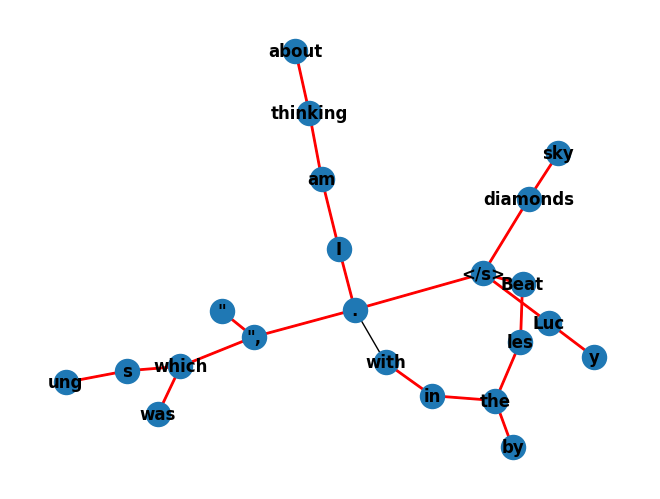

In [19]:
generate_mst(input_ids, tokenizer, encoder_hidden_states)